In [1]:
import numpy as np
import pandas as pd

import os
import io

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dropout, Activation
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

from keras.utils.vis_utils import plot_model

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [3]:
!nvidia-smi

Tue Apr 11 18:57:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti    WDDM | 00000000:01:00.0  On |                  N/A |
| 57%   58C    P8               16W / 200W|    533MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
csv_files = os.listdir('H:/Datasets/InSDN')
df = pd.DataFrame()

li = []

for filename in csv_files:
    df = pd.read_csv(os.path.join('H:/Datasets/InSDN', filename), low_memory=False, index_col=None, header=0)
    li.append(df)
    print("Read in {}".format(filename))

df = pd.concat(li, axis=0, ignore_index=True)

print("Finisehd reading in {} entires".format(str(df.shape[0])))

Read in metasploitable-2.csv
Read in Normal_data.csv
Read in OVS.csv
Finisehd reading in 343889 entires


In [5]:
metadata = ['Flow ID',
'Src IP',
'Src Port',
'Dst IP',
'Dst Port',
'Protocol',
'Timestamp',
'Flow Duration',
'Tot Fwd Pkts',
'Tot Bwd Pkts',
'TotLen Fwd Pkts',
'TotLen Bwd Pkts',
'Fwd Pkt Len Max',
'Fwd Pkt Len Min',
'Fwd Pkt Len Mean',
'Fwd Pkt Len Std',
'Bwd Pkt Len Max',
'Bwd Pkt Len Min',
'Bwd Pkt Len Mean',
'Bwd Pkt Len Std',
'Flow Byts/s',
'Flow Pkts/s',
'Flow IAT Mean',
'Flow IAT Std',
'Flow IAT Max',
'Flow IAT Min',
'Fwd IAT Tot',
'Fwd IAT Mean',
'Fwd IAT Std',
'Fwd IAT Max',
'Fwd IAT Min',
'Bwd IAT Tot',
'Bwd IAT Mean',
'Bwd IAT Std',
'Bwd IAT Max',
'Bwd IAT Min',
'Fwd PSH Flags',
'Bwd PSH Flags',
'Fwd URG Flags',
'Bwd URG Flags',
'Fwd Header Len',
'Bwd Header Len',
'Fwd Pkts/s',
'Bwd Pkts/s',
'Pkt Len Min',
'Pkt Len Max',
'Pkt Len Mean',
'Pkt Len Std',
'Pkt Len Var',
'FIN Flag Cnt',
'SYN Flag Cnt',
'RST Flag Cnt',
'PSH Flag Cnt',
'ACK Flag Cnt',
'URG Flag Cnt',
'CWE Flag Count',
'ECE Flag Cnt',
'Down/Up Ratio',
'Pkt Size Avg',
'Fwd Seg Size Avg',
'Bwd Seg Size Avg',
'Fwd Byts/b Avg',
'Fwd Pkts/b Avg',
'Fwd Blk Rate Avg',
'Bwd Byts/b Avg',
'Bwd Pkts/b Avg',
'Bwd Blk Rate Avg',
'Subflow Fwd Pkts',
'Subflow Fwd Byts',
'Subflow Bwd Pkts',
'Subflow Bwd Byts',
'Init Fwd Win Byts',
'Init Bwd Win Byts',
'Fwd Act Data Pkts',
'Fwd Seg Size Min',
'Active Mean',
'Active Std',
'Active Max',
'Active Min',
'Idle Mean',
'Idle Std',
'Idle Max',
'Idle Min',
'Label'
]

In [6]:
df.columns = metadata

In [7]:
df["Label"].value_counts()

DDoS          121942
Probe          98129
Normal         68424
DoS            53616
BFA             1405
Web-Attack       192
BOTNET           164
U2R               17
Name: Label, dtype: int64

In [8]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

<Figure size 1440x1440 with 0 Axes>

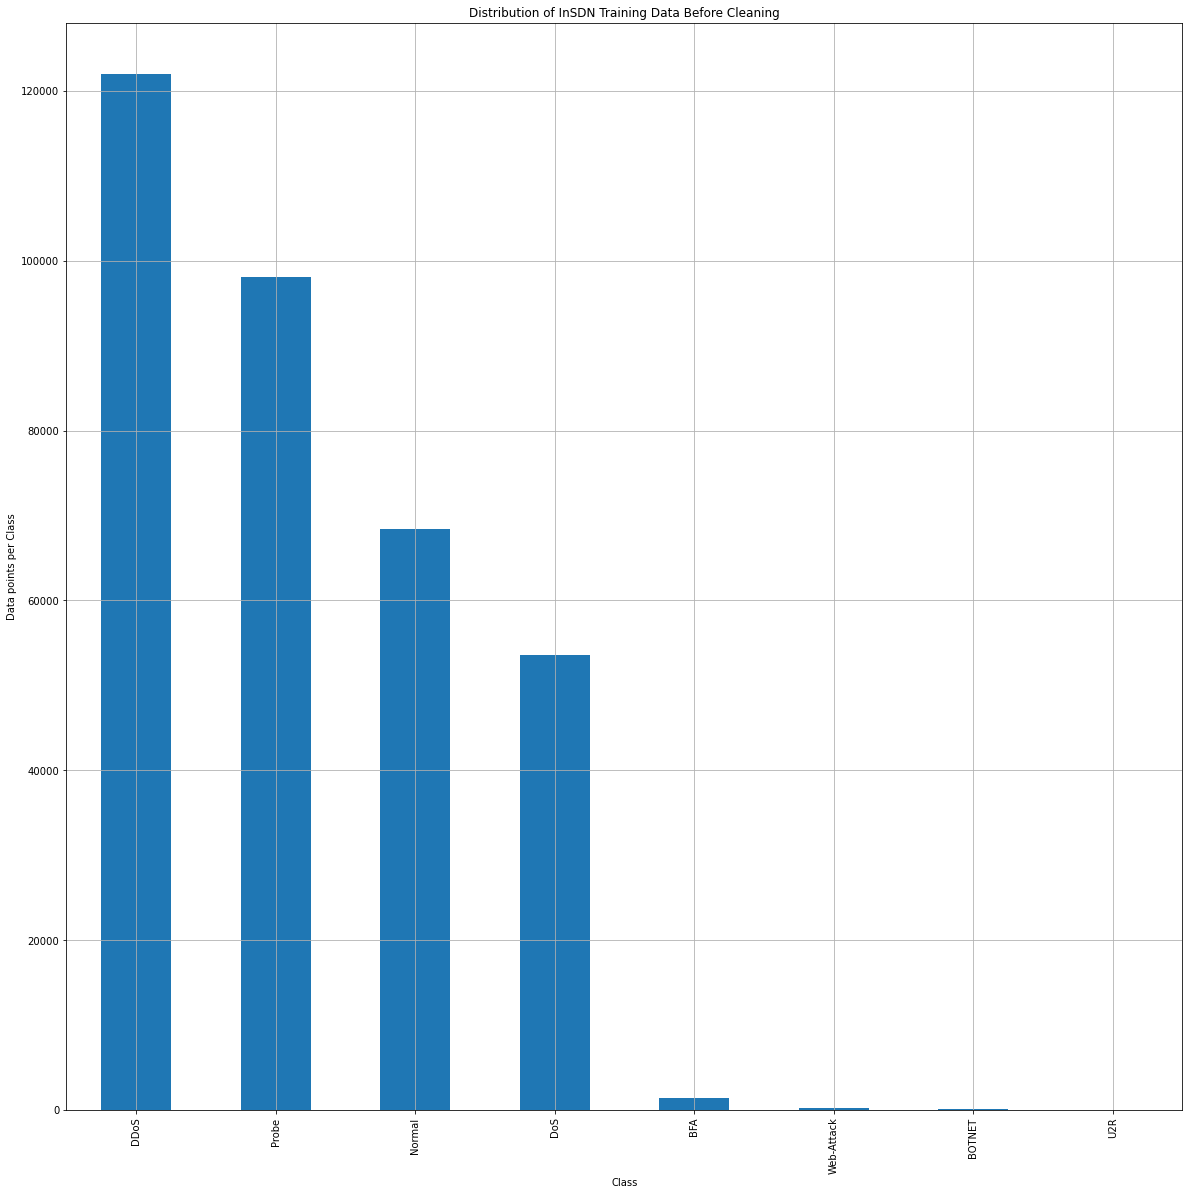

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(20,20))

class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of InSDN Training Data Before Cleaning')
plt.grid()
plt.show()

fig.savefig('InSDN_Data_Distribution.pdf') 

In [10]:
# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class DDoS : 121942 ( 35.46 %)
Number of data points in class Probe : 98129 ( 28.535 %)
Number of data points in class Normal : 68424 ( 19.897 %)
Number of data points in class DoS : 53616 ( 15.591 %)
Number of data points in class BFA : 1405 ( 0.409 %)
Number of data points in class Web-Attack : 192 ( 0.056 %)
Number of data points in class BOTNET : 164 ( 0.048 %)
Number of data points in class U2R : 17 ( 0.005 %)


In [11]:
#drop na values and reset index
data_clean = df.dropna().reset_index()

# Checkng for DUPLICATE values
data_clean.drop_duplicates(keep='first', inplace = True)

data_clean['Label'].value_counts()

print("Read {} rows.".format(len(data_clean)))

Read 343889 rows.


In [12]:
# Remove columns with only values of 0
useless_columns = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port']
data_clean.drop(labels=useless_columns, axis='columns', inplace=True)
print('After dropping some columns: \n\t there are {} columns and {} rows'.format(len(data_clean.columns), len(data_clean)))

#features = df.columns

After dropping some columns: 
	 there are 79 columns and 343889 rows


In [13]:
analyze(data_clean)


343889 rows
** index:343889 (100%)
** Protocol:[6:54.68%,0:35.43%,17:9.89%]
** Flow Duration:85380 (24%)
** Tot Fwd Pkts:569 (0%)
** Tot Bwd Pkts:699 (0%)
** TotLen Fwd Pkts:5602 (1%)
** TotLen Bwd Pkts:7585 (2%)
** Fwd Pkt Len Max:2132 (0%)
** Fwd Pkt Len Min:[0:90.5%,34:1.41%,30:1.33%,32:1.13%,33:0.96%,95:0.85%,36:0.52%,40:0.44%,35:0.41%,42:0.26%,38:0.22%,51:0.21%,50:0.19%,37:0.18%,31:0.15%,45:0.14%,39:0.14%,43:0.11%,46:0.09%,174:0.09%,47:0.09%,60:0.08%,48:0.07%,44:0.06%,29:0.06%,49:0.04%,178:0.04%,22:0.04%,41:0.03%,28:0.03%,27:0.02%,137:0.01%,1300:0.01%,2600:0.01%,200:0.0%,52:0.0%,86:0.0%,90:0.0%,65:0.0%,53:0.0%,77:0.0%,83:0.0%,25:0.0%,498:0.0%,55:0.0%,59:0.0%,3900:0.0%,1210:0.0%,161:0.0%,58:0.0%,156:0.0%,247:0.0%,61:0.0%,152:0.0%,23:0.0%,133:0.0%,476:0.0%,207:0.0%,488:0.0%,54:0.0%,509:0.0%,3810:0.0%,519:0.0%,2510:0.0%,154:0.0%,1211:0.0%,327:0.0%,274:0.0%,2521:0.0%,309:0.0%,317:0.0%,436:0.0%,1:0.0%,5:0.0%,10:0.0%,57:0.0%]
** Fwd Pkt Len Mean:9698 (2%)
** Fwd Pkt Len Std:11879 (3%)


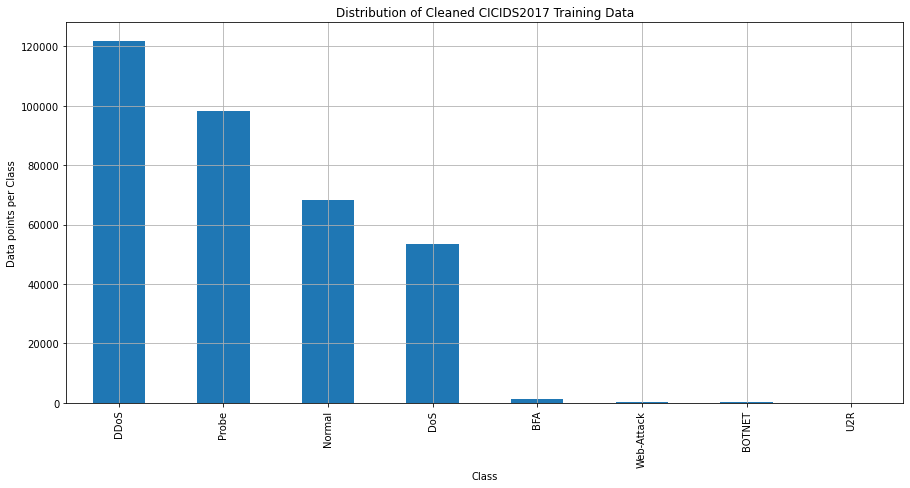

In [14]:
plt.figure(figsize=(15,7))
class_distribution = data_clean['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICIDS2017 Training Data')
plt.grid()
plt.show()

In [15]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/data_clean.shape[0]*100), 3), '%)')

Number of data points in class DDoS : 121942 ( 35.46 %)
Number of data points in class Probe : 98129 ( 28.535 %)
Number of data points in class Normal : 68424 ( 19.897 %)
Number of data points in class DoS : 53616 ( 15.591 %)
Number of data points in class BFA : 1405 ( 0.409 %)
Number of data points in class Web-Attack : 192 ( 0.056 %)
Number of data points in class BOTNET : 164 ( 0.048 %)
Number of data points in class U2R : 17 ( 0.005 %)


In [16]:
# Convert to numpy - Classification
x_columns = data_clean.columns.drop('Label')
x = data_clean[x_columns].values
dummies = pd.get_dummies(data_clean['Label']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:77]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,78:]).toarray()

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.35, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

In [19]:
X.shape

(343889, 77)

In [20]:
Y.shape

(343889, 8)

In [21]:
data = data_clean.iloc[:,1:-1]

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [23]:
corr = data.corr()

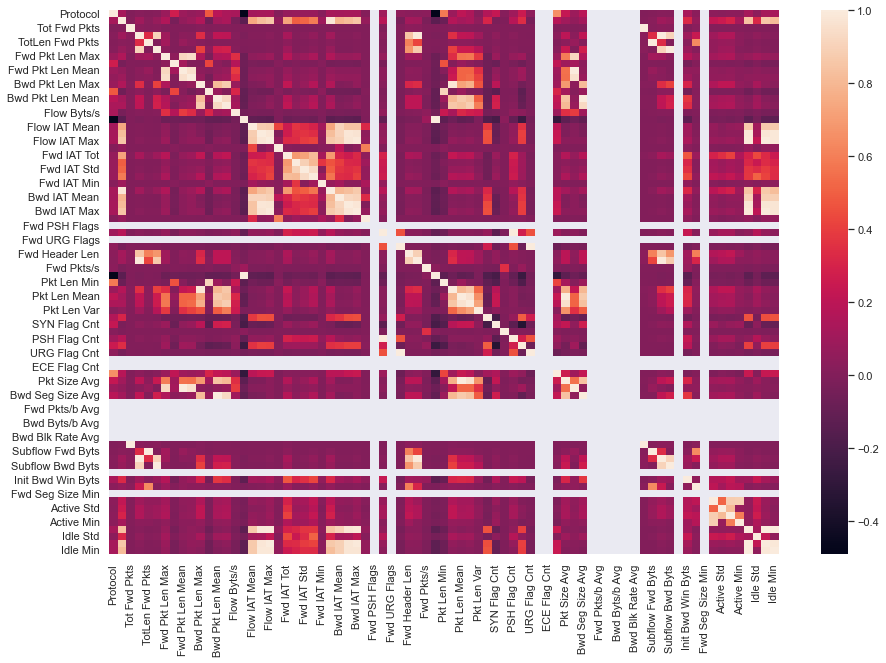

In [24]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr)

plt.savefig('Data_corelation.eps')

# DCNN 1D

In [27]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, MaxPooling1D, Dropout, BatchNormalization, AveragePooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], 77, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 77, 1).astype('float32')


# DCNN Model
model = Sequential()
model.add(Convolution1D(filters=96, kernel_size=6, input_shape=(_features, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.1))

model.add(Convolution1D(filters=128, kernel_size=6, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation = 'softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 72, 96)            672       
                                                                 
 batch_normalization_4 (Batc  (None, 72, 96)           384       
 hNormalization)                                                 
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 36, 96)           0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 36, 96)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 31, 128)           73856     
                                                                 
 batch_normalization_5 (Batc  (None, 31, 128)         

In [28]:
print('Saving the model')   
    
model.save('H:/Datasets/DCNNs/conv1d_model_cnn.h5')
print('Done!') 

Saving the model
Done!


In [29]:
import datetime as dt
import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

y_test = Y_test.argmax(axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred, multi_class='ovr') #ovr: One-vs-rest     ovo: One-vs-one

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

3762/3762 [==============================] - 5s 1ms/step
Completed
Time taken: 0:00:14.948537
Inference time: 6.62 seconds
Validation score: 0.9993934962862033
Evaluation score: [0.0004920540959574282, 0.9993935227394104]
Recall score: 0.9993934962862033
Precision score: 0.9993527303633337
F1 Measure score: 0.999372909363011
ROC-AUC score: 0.9361495135906164


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [31]:
pred.shape
y_test.shape

(120362,)

In [40]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

3762/3762 [==============================] - 5s 1ms/step


In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  506,     0,     0,     1,     0,     0,     0,     0],
       [    0,    63,     0,     0,     0,     0,     0,     0],
       [    0,     0, 42691,     0,     1,     0,     0,     0],
       [    0,     0,     2, 18738,     3,    34,     0,     0],
       [    0,     0,     5,     3, 23842,     0,     0,     0],
       [    0,     0,     0,     9,     6, 34387,     0,     3],
       [    1,     0,     0,     2,     0,     2,     0,     0],
       [    0,     0,     0,     1,     0,     0,     0,    62]],
      dtype=int64)

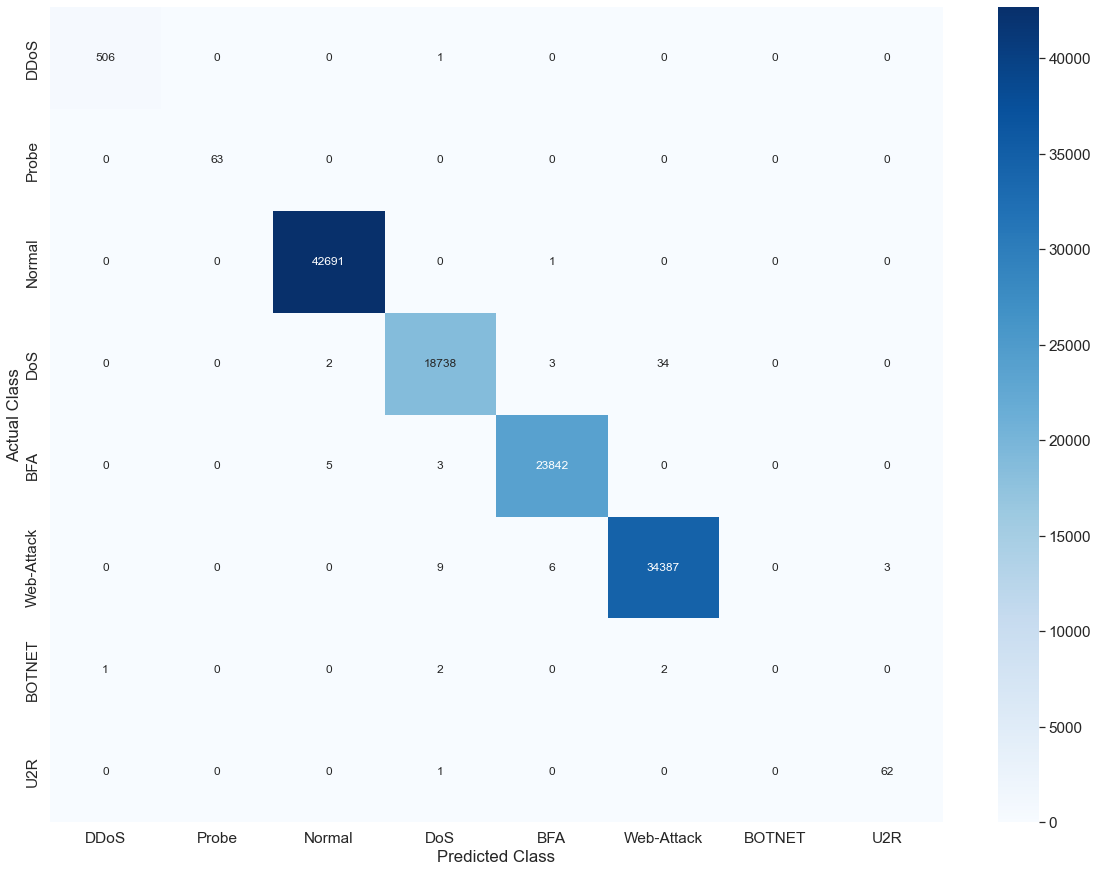

In [42]:
cm_df = pd.DataFrame(confMat)

labels = ['DDoS','Probe','Normal','DoS','BFA','Web-Attack','BOTNET','U2R']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

# DCNN 1D

In [55]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, MaxPooling1D, Dropout, BatchNormalization, AveragePooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], 77, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 77, 1).astype('float32')


# DCNN Model
model = Sequential()
model.add(Convolution1D(filters=96, kernel_size=6, input_shape=(_features, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.1))

model.add(Convolution1D(filters=128, kernel_size=6, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation = 'softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 72, 96)            672       
                                                                 
 batch_normalization_8 (Batc  (None, 72, 96)           384       
 hNormalization)                                                 
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 36, 96)           0         
 1D)                                                             
                                                                 
 dropout_24 (Dropout)        (None, 36, 96)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 31, 128)           73856     
                                                                 
 batch_normalization_9 (Batc  (None, 31, 128)        

In [ ]:
print('Saving the model')   
    
model.save('H:/Datasets/DCNNs/conv1d_0001_model_cnn.h5')
print('Done!') 

In [56]:
import datetime as dt
import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

y_test = Y_test.argmax(axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred, multi_class='ovr') #ovr: One-vs-rest     ovo: One-vs-one

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

3762/3762 [==============================] - 6s 2ms/step
Completed
Time taken: 0:00:16.023126
Inference time: 7.22 seconds
Validation score: 0.9994516541765673
Evaluation score: [0.0035671766381710768, 0.9994516372680664]
Recall score: 0.9994516541765673
Precision score: 0.9994225030385108
F1 Measure score: 0.9994305709530228
ROC-AUC score: 0.9253253288077053


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
pred.shape
y_test.shape

(120362,)

In [58]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

3762/3762 [==============================] - 6s 2ms/step


In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  506,     0,     0,     0,     0,     1,     0,     0],
       [    0,    63,     0,     0,     0,     0,     0,     0],
       [    0,     0, 42689,     0,     3,     0,     0,     0],
       [    0,     1,     2, 18769,     2,     3,     0,     0],
       [    5,     0,     1,     3, 23841,     0,     0,     0],
       [    0,     0,     5,    17,     3, 34377,     0,     3],
       [    1,     0,     0,     1,     0,     3,     0,     0],
       [    0,    11,     0,     1,     0,     0,     0,    51]],
      dtype=int64)

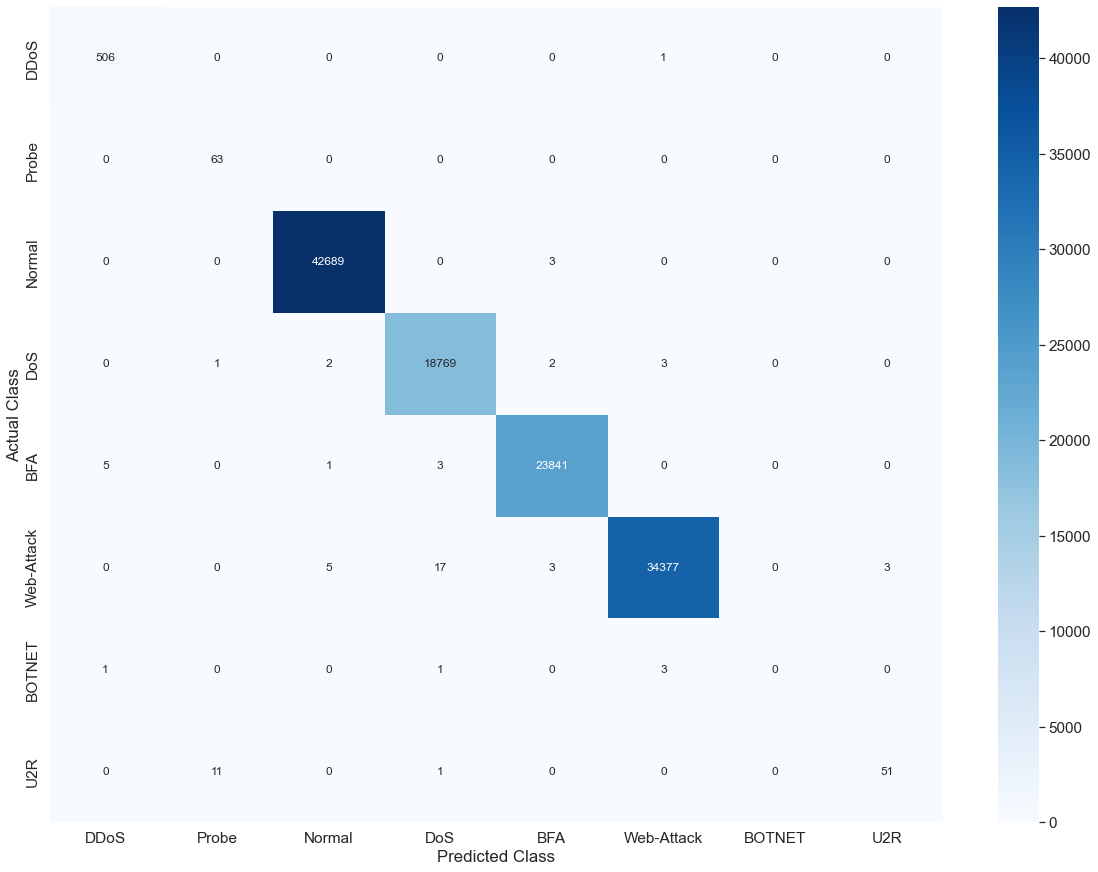

In [60]:
cm_df = pd.DataFrame(confMat)

labels = ['DDoS','Probe','Normal','DoS','BFA','Web-Attack','BOTNET','U2R']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

# DCNN 1D

In [61]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, MaxPooling1D, Dropout, BatchNormalization, AveragePooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], 77, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 77, 1).astype('float32')


# DCNN Model
model = Sequential()
model.add(Convolution1D(filters=96, kernel_size=6, input_shape=(_features, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.1))

model.add(Convolution1D(filters=128, kernel_size=6, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation = 'softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 72, 96)            672       
                                                                 
 batch_normalization_10 (Bat  (None, 72, 96)           384       
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 36, 96)           0         
 g1D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 36, 96)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 31, 128)           73856     
                                                                 
 batch_normalization_11 (Bat  (None, 31, 128)        

In [62]:
print('Saving the model')   
    
model.save('H:/Datasets/DCNNs/conv1d_01_model_cnn.h5')
print('Done!') 

Saving the model
Done!


In [63]:
import datetime as dt
import time
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

y_test = Y_test.argmax(axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred, multi_class='ovr') #ovr: One-vs-rest     ovo: One-vs-one

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

3762/3762 [==============================] - 5s 1ms/step
Completed
Time taken: 0:00:14.683280
Inference time: 6.31 seconds
Validation score: 0.6392632226117878
Evaluation score: [0.18599621951580048, 0.6392632126808167]
Recall score: 0.6392632226117878
Precision score: 0.4111417497808988
F1 Measure score: 0.49993920548130866
ROC-AUC score: 0.5916337738664954


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
pred.shape
y_test.shape

(120362,)

In [65]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

3762/3762 [==============================] - 5s 1ms/step


In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[    0,     0,     0,     0,     0,   507,     0,     0],
       [    0,     0,     0,     0,     0,    63,     0,     0],
       [    0,     0, 42543,     0,     0,   149,     0,     0],
       [    0,     0,    68,     0,     0, 18709,     0,     0],
       [    0,     0, 20148,     0,     0,  3702,     0,     0],
       [    0,     0,     5,     0,     0, 34400,     0,     0],
       [    0,     0,     0,     0,     0,     5,     0,     0],
       [    0,     0,     0,     0,     0,    63,     0,     0]],
      dtype=int64)

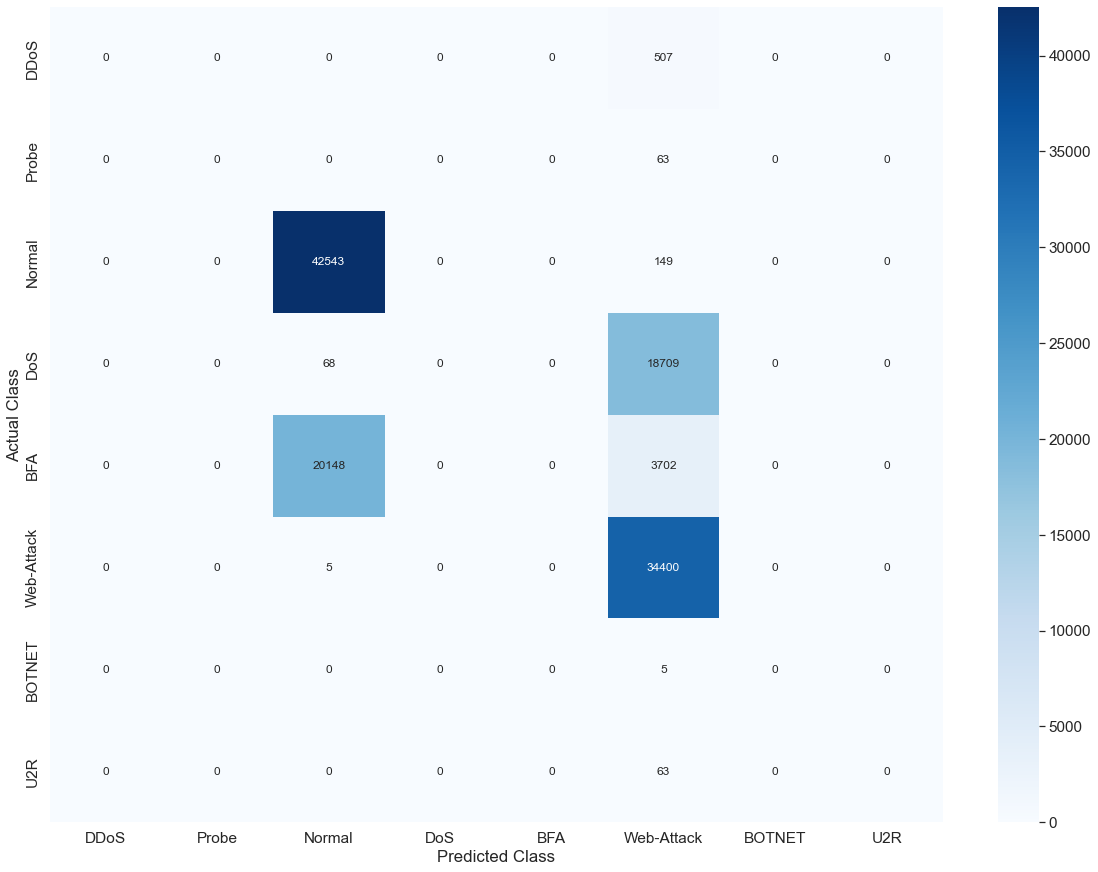

In [67]:
cm_df = pd.DataFrame(confMat)

labels = ['DDoS','Probe','Normal','DoS','BFA','Web-Attack','BOTNET','U2R']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 